# Project Overview

Where to invest at NYC that would be more profitable, if he wanted to buy a two bedroom house and turned it into Airbnb for most of the time. 

**ROI = (Annual Rental Income – Expenses and Costs) / the Property Price**

**Annual Rental Income:** 
75% occupancy rate is used to estimate the yearly rent revenue. This oversimplified estimation could be fine-tuned if we had booking history data. 

Only the Airbnb rental price per night for Entire home/apt and 2-bedroom property will be used as the rental income reference. All the rental price were scraped in July 2019, which is reasonably close to 2020. Thus, no adjustment will be made on the rental price.

As shown in the `DataQualityCheck` documentation, the majority of the rent price data are from New York, thus, this analysis would narrow the invesment scope to zipcodes in New York City. 

**Expenses and costs:** The cost relating to keeping the business running and owning the houses, such as, utility, cleaning services and property taxes. I assume the cleaning fee travelers pay would be enough to cover the utility and cleaning services. And I do not include property taxes into account for simplicity. Therefore the only cost left is the property cost. 

**Property Price:** As the project statement states, interest rate do not come into play, which makes the analysis easier. The property cost provided dates back to at the lastest June 2017, whereas, the investments are yet to be made in 2020. Therefore, I will make a prediction model to predict the home value in Jan 2020.   

Now the question becomes which zipcodes should the my friend invest property at to maximize the short-term rental ROI in New York in 2020? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = None

In [2]:
listing_fname = 'listing_cleaned.csv'
zillow_fname = 'zillow_cleaned.csv'

In [3]:
listing = pd.read_csv(listing_fname)
zillow = pd.read_csv(zillow_fname)

In [4]:
listing.head(2)

,id,last_scraped,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,last_review,number_of_reviews
0,2595,2019-07-09,"New York, NY, United States",Midtown,Manhattan,New York,NY,10018.0,New York,US,United States,40.75362,-73.98377,Apartment,Entire home/apt,2,1.0,0.0,Real Bed,NaN,225.0,1995.0,NaN,350.0,100.0,2,0.0,4 days ago,t,25,55,80,355,2019-07-09,2019-05-21,45
1,3831,2019-07-09,"Brooklyn, NY, United States",Clinton Hill,Brooklyn,Brooklyn,NY,11238.0,New York,US,United States,40.68514,-73.95976,Guest suite,Entire home/apt,3,1.0,1.0,Real Bed,500.0,89.0,575.0,2100.0,500.0,NaN,1,0.0,today,t,0,0,3,194,2019-07-09,2019-07-05,270


## Home Value Prediction

Short-term rental business is a well sought after business model. All the investors out there should have exploited all the possibility. It is reasonable to think that if there is zero Airbnb listing on certain locations, it probably suggests that those zipcodes are not suitable for Airbnb business. After filtering for zipcodes that have Airbnb rental price, the potential profitable zipcodes went down from 264 to 29. The next step is to predict the median home value in 2020 


In [5]:
# zipcodes in New York and have rental price information
zillow = zillow[zillow.Metro == 'New York']
print('There are {} zipcodes in New York Metro Area'.format(zillow.shape[0]))
zillow = zillow[zillow.RegionName.isin(listing.zipcode.unique())]
print('After filtering for areas that have Airbnb listings, only {} are left.'.format(zillow.shape[0]))

There are 264 zipcodes in New York Metro Area
After filtering for areas that have Airbnb listings, only 29 are left.


In [6]:
# convert from wide format to long format
zillow_melted = pd.melt(zillow, id_vars=['RegionID', 'RegionName', 'City', 'State', 
                                         'Metro', 'CountyName', 'SizeRank'], var_name='YM')
zillow_melted.set_index('YM', inplace=True)
zillow_melted.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
YM,,,,,,,,
1996-04,61639,10025,New York,NY,New York,New York,1,NaN
1996-04,61637,10023,New York,NY,New York,New York,3,NaN


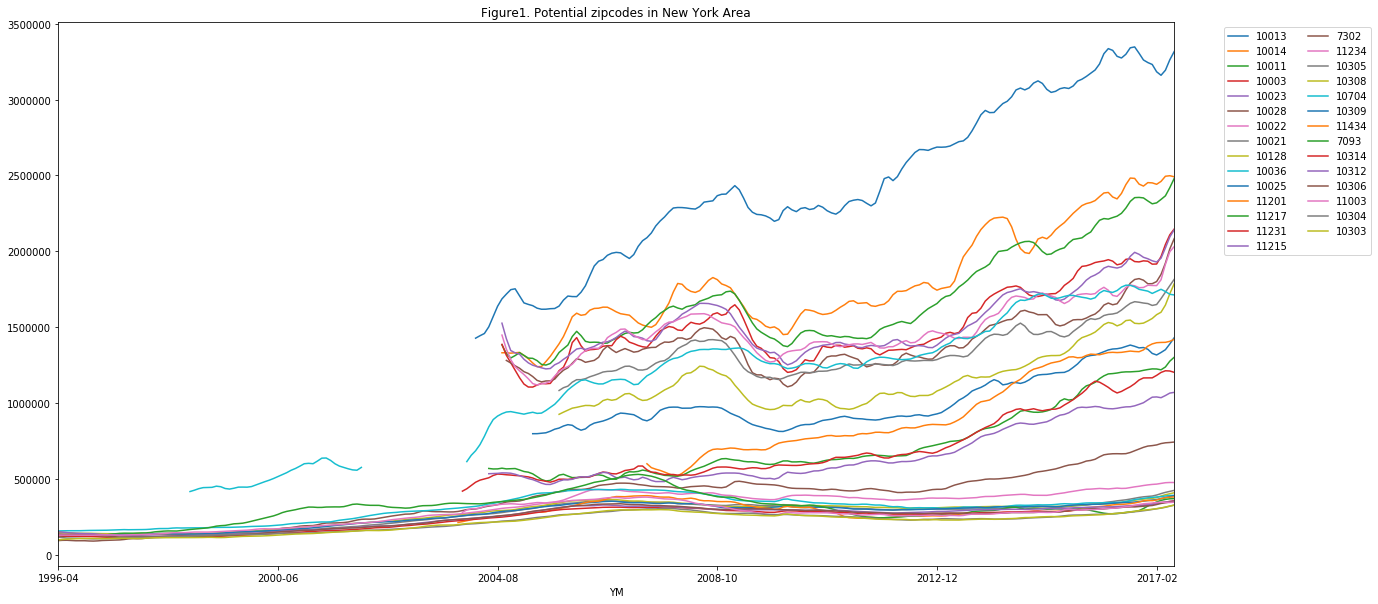

In [7]:
plt.figure(figsize=(20,10))
for zipcode in zillow.sort_values('2017-06', ascending = False).iloc[0:50].RegionName:
    zillow_melted.loc[zillow_melted['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.title('Figure1. Potential zipcodes in New York Area')
plt.show()

Most zipcodes do not change a lot in comparison to the more expensive areas, whereas the more expensive areas doubled from 2004 to 2017. There were obvious downturns in 2008-2009, experiencing the aftermath of the financial crisis. But New York being New York, the housing market comes back strongly, with nearly 3.5M for a 2-bedroom in the most expensive area 10013, SOHO in lower Manhattan.

In addition, zipcode 10036 has 2 years data missing from 2002 to 2003. This gap is too big to use linear interpolation to fill, so I only keep data since 2004.

In [8]:
# keep data from 2004 onward
zillow.loc[zillow.RegionName == 10036, '1996-04':'2003-12'] = None
# convert from wide format to long format again
zillow_melted = pd.melt(zillow, id_vars=['RegionID', 'RegionName', 'City', 'State', 
                                         'Metro', 'CountyName', 'SizeRank'], var_name='YM')
zillow_melted.set_index('YM', inplace=True)

### Modeling
Due to the time constraint, I use Facebook Prophet package to build forecasting model. Prophet abstracts away the complexity of time series prediction, letting people make meaningful prediction with few lines of codes. 

Box Cox transformation is a way to transform non-normal dependent variables into a normal shape, a widly used data preparation in time series modeling. Using the last 2.5 years data as test data, I want to compare the model performance on original data and boxcox-transformed data. However, After trying different way to reduce the scale of home value(logtransformation, division, etc), the inversed-boxcox transformation process still kept generating infinite number prediction. So I ended up directly using Prophet to generate predictions without any comparison.

The comparison graph of actual and prediction would not be satisfying for a rigorous prediction competition. It is pretty dubious to use past 10 years housing value only to predict 2.5 years into the future, after all we housing market could not simply be explained by seasonal or monthly trends. However, due to the time constraint and lack of more indicative features such as crime rate, I am going with this makeshift prediction method.

By using the historical median home value, the model would predict median home value up till Jan 2020.

In [9]:
from fbprophet import Prophet
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [10]:
def prepare_data(melted_data, zipcode, prediction_period):
    df = melted_data.loc[melted_data['RegionName'] == zipcode, ['value']].reset_index()
    df = df.rename(columns={'YM': 'ds','value': 'y'})
    df = df[df.y.notna().idxmax():]
    df['ds'] = pd.to_datetime(df['ds'])
    df_train = df[:-prediction_period]
    return df, df_train

In [11]:
def comparison_plot(comp_df, zipcode, prediction_period, draw_predicted_period = True):
    plt.figure(figsize=(20,8))
    ax = plt.subplot(111)
    ax.plot(comp_df['y'],'ro',markersize=3,label = 'actual')
    if draw_predicted_period:
        ax.plot(comp_df[-prediction_period:]['yhat'],'g', markersize=3, label = 'prediction')
        plt.fill_between(comp_df.index[-prediction_period:], comp_df[-prediction_period:]['yhat_upper'], comp_df[-prediction_period:]['yhat_lower'], alpha = 0.5)
    else:
        ax.plot(comp_df['yhat'],'g', markersize=3, label = 'prediction')
        plt.fill_between(comp_df.index, comp_df['yhat_upper'], comp_df['yhat_lower'], alpha = 0.5)
    plt.title('Actual home value vs prediction for zipcode {}'.format(zipcode))
    plt.ylabel('Median Home Value')
    plt.legend()
    plt.show()

In [12]:
def make_prediction(data, prediction_period = 36, freq = "MS" ,plot = False, boxcox_transformed = False):
    df = data.copy()
    if boxcox_transformed:
        df.set_index('ds', inplace = True)
        df['y'], lamb = boxcox(df['y'])
        df.reset_index(inplace=True)
    
    #print(df)      
    # train model and make prediction
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods = prediction_period, freq = freq)
    forecast = m.predict(future)
    if plot:
        m.plot(forecast)
        m.plot_components(forecast)
    #print(forecast[['yhat']])
    
    # reverse transformed the predicted value
    if boxcox_transformed:
        forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lamb))
    #print('after reverse')
    #print(forecast[['yhat']])
    return forecast[['ds','yhat','yhat_upper','yhat_lower']], m

MAPE is a commonly used evaluation metrics for forecast, because it does not depend on scale and can apply easily to both high and low housing price. 

In [13]:
# referencing from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc
def calculate_forecast_errors(df, prediction_period):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_period:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [14]:
prediction_period = 36
# prediction error without transformation
MAPE_ntrnf = []
MAE_ntrnf = []
# # prediction error with boxcox transformed version
# MAPE_boxcox = [] 
# MAE_boxcox = []

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10025


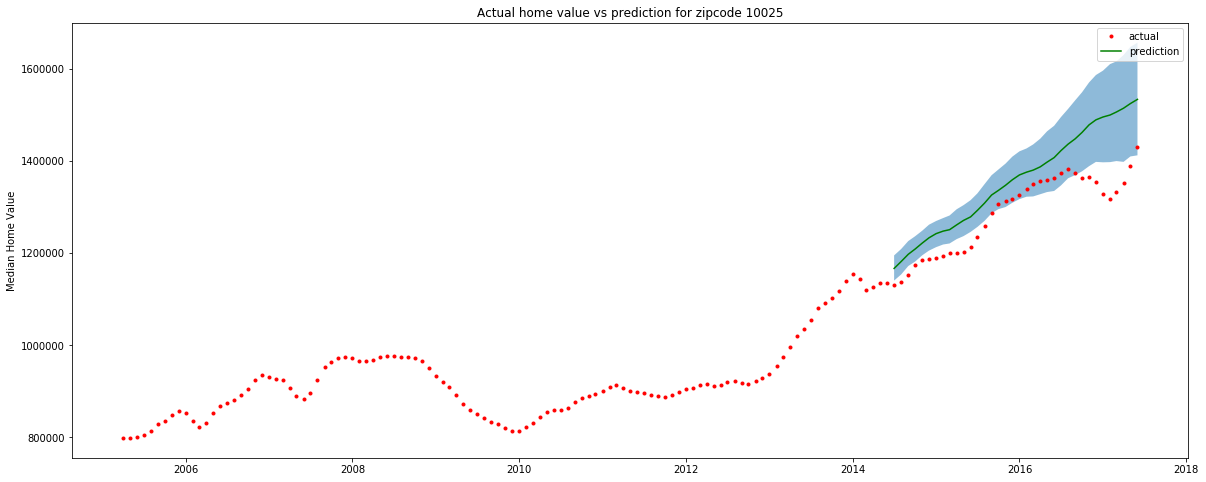

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10023


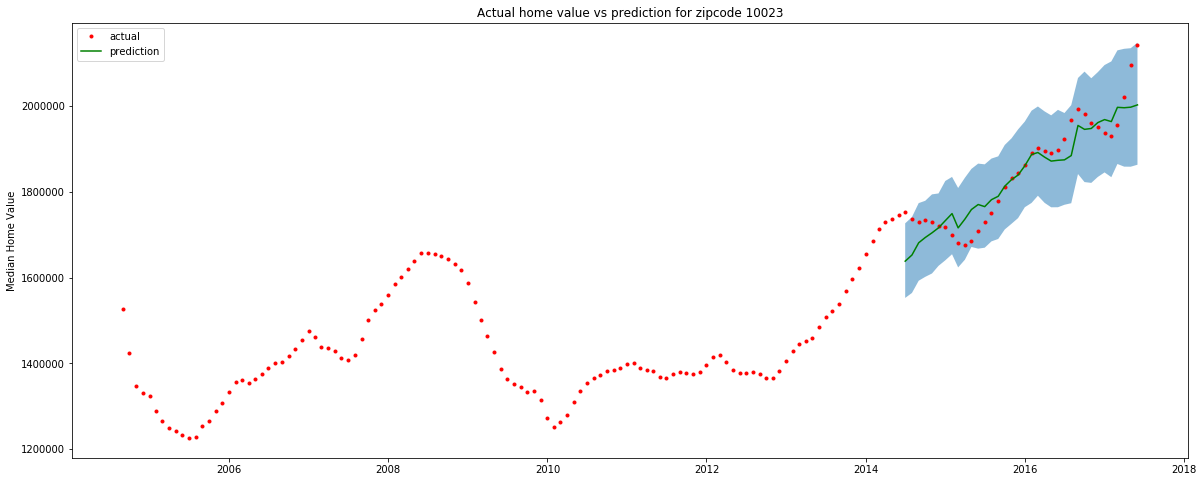

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10128


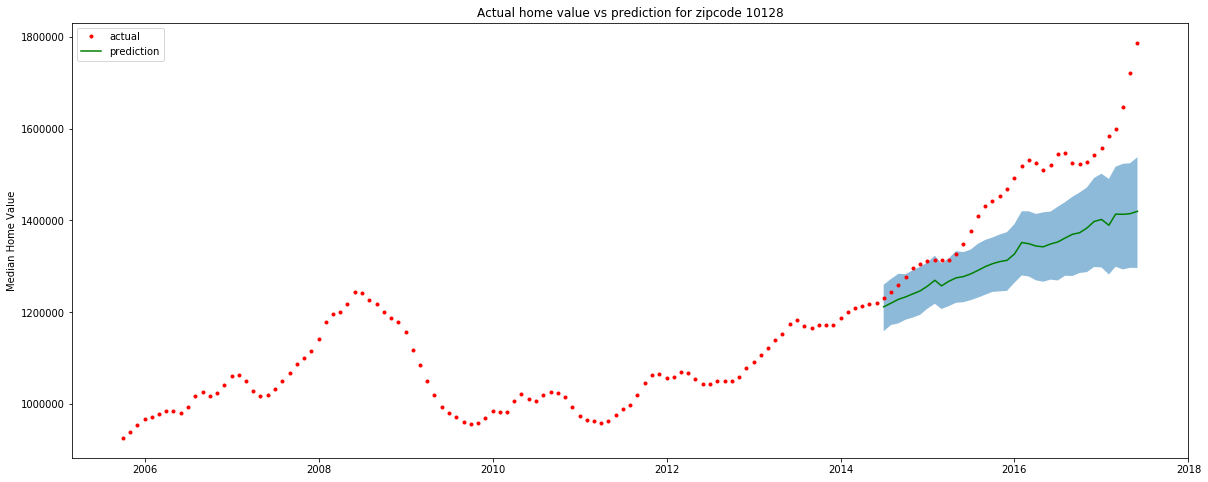

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10011


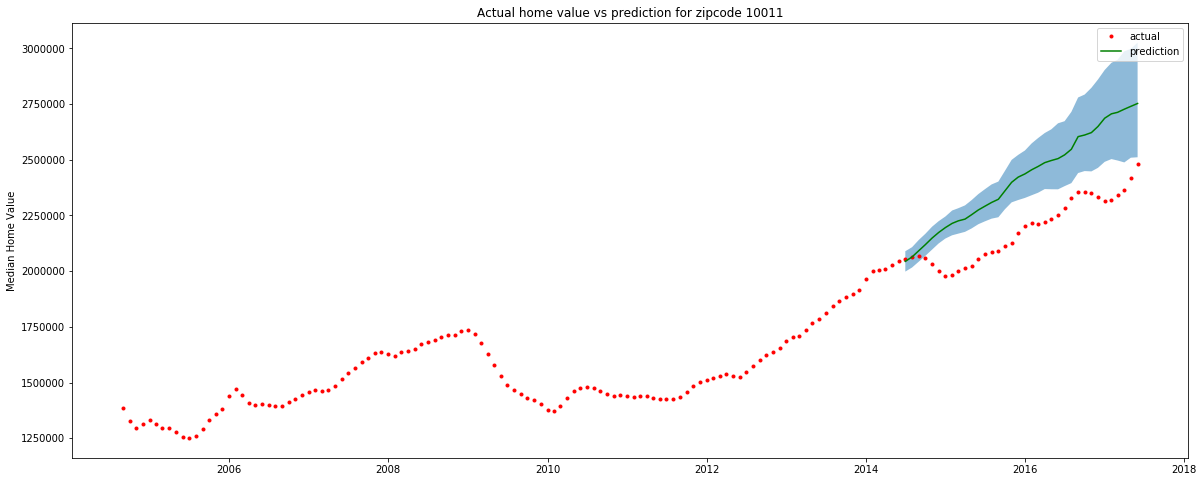

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10003


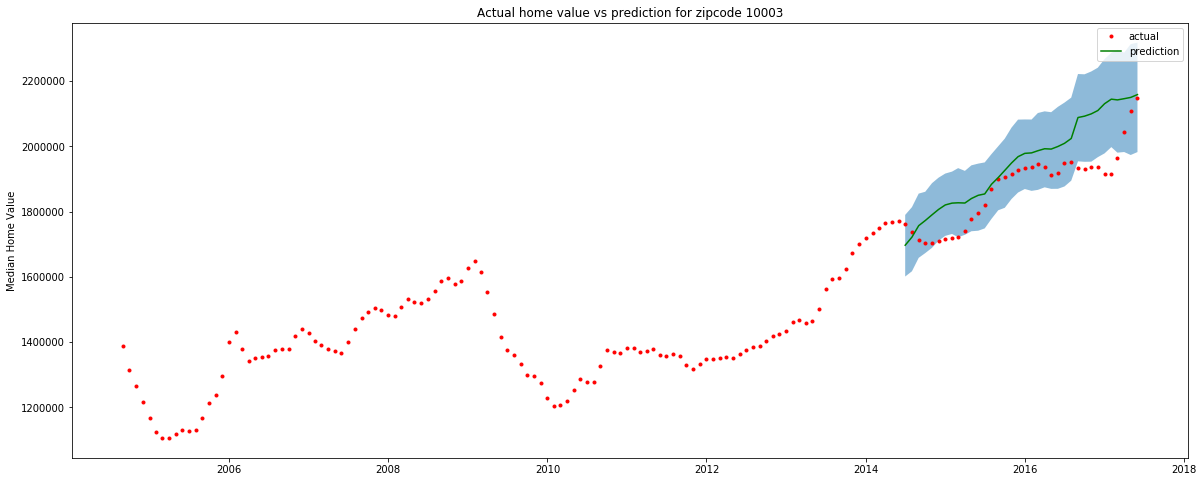

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11201


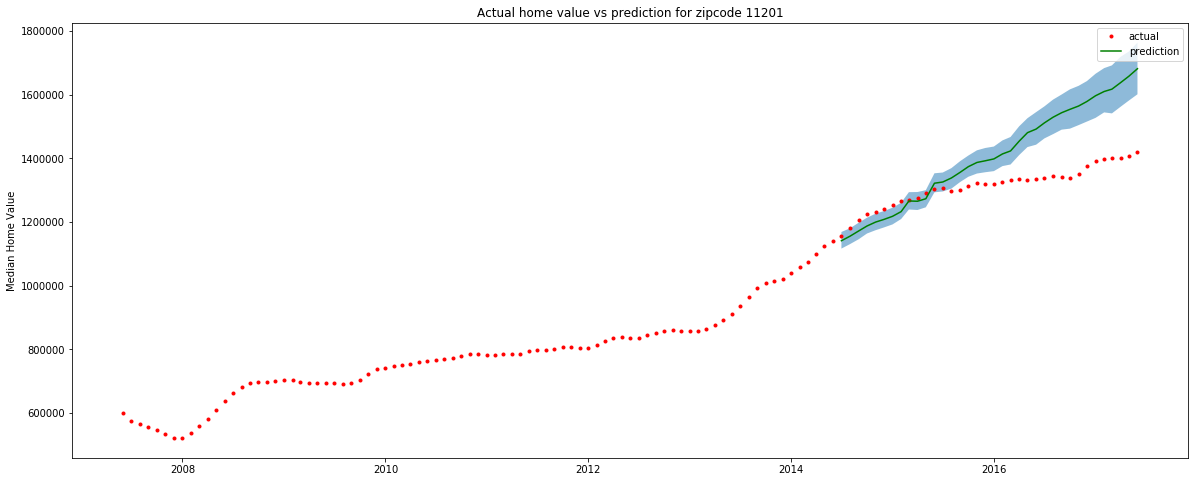

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11234


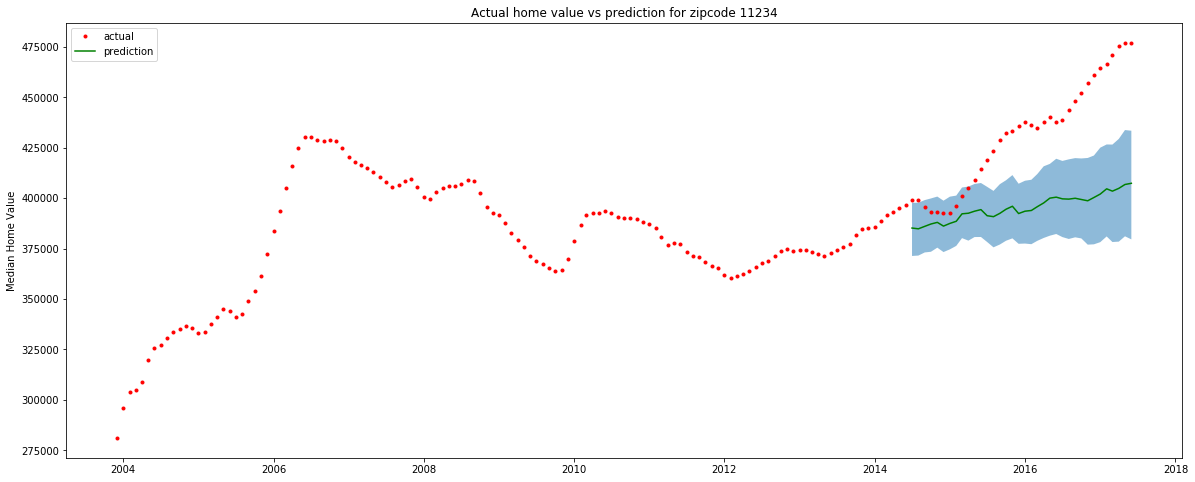

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10314


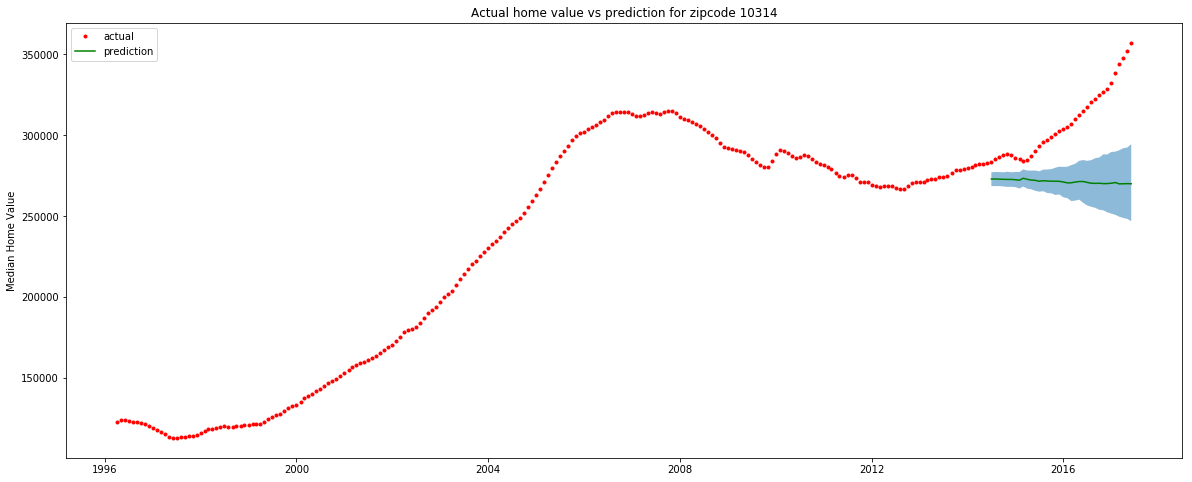

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11215


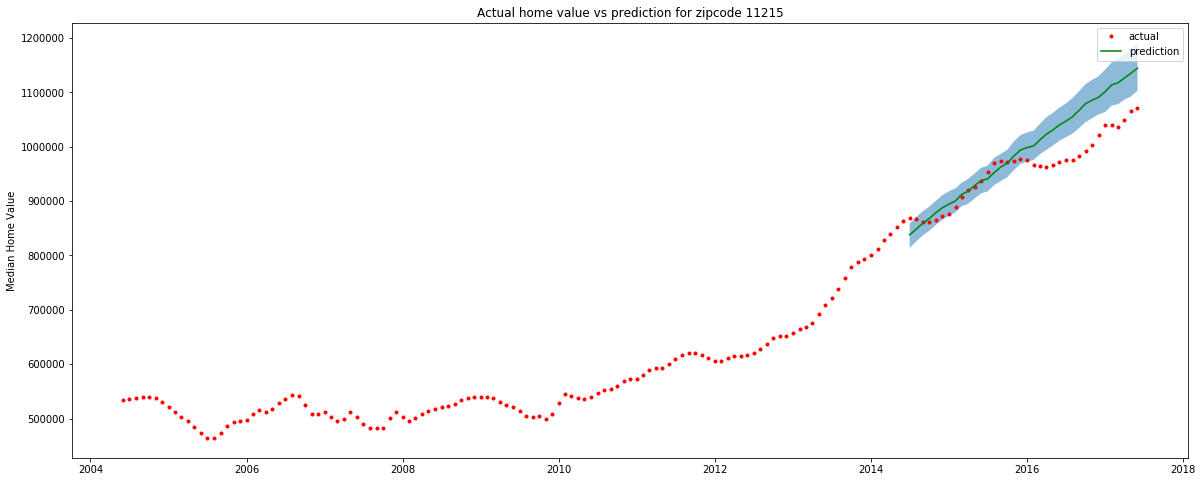

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10028


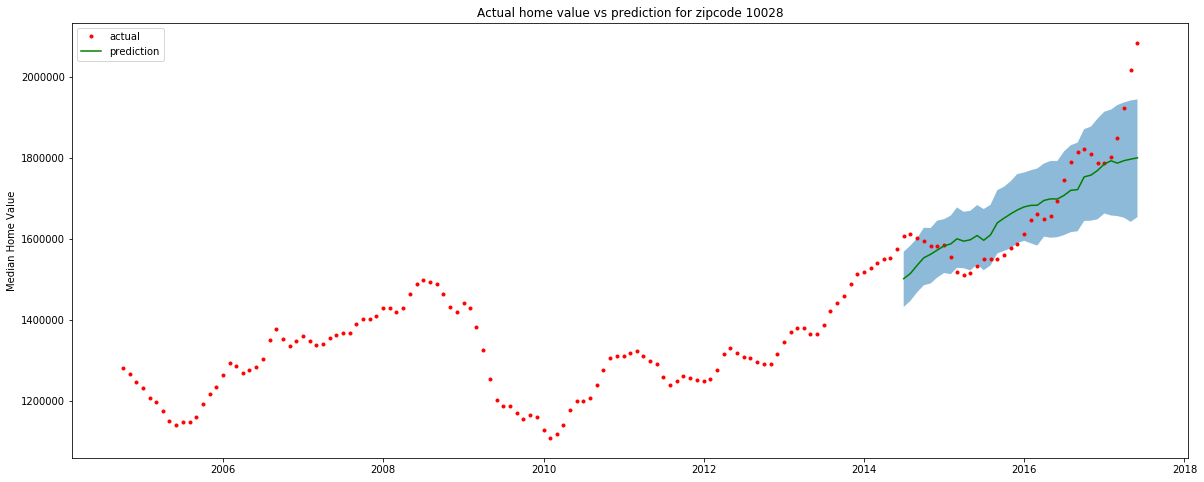

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7093


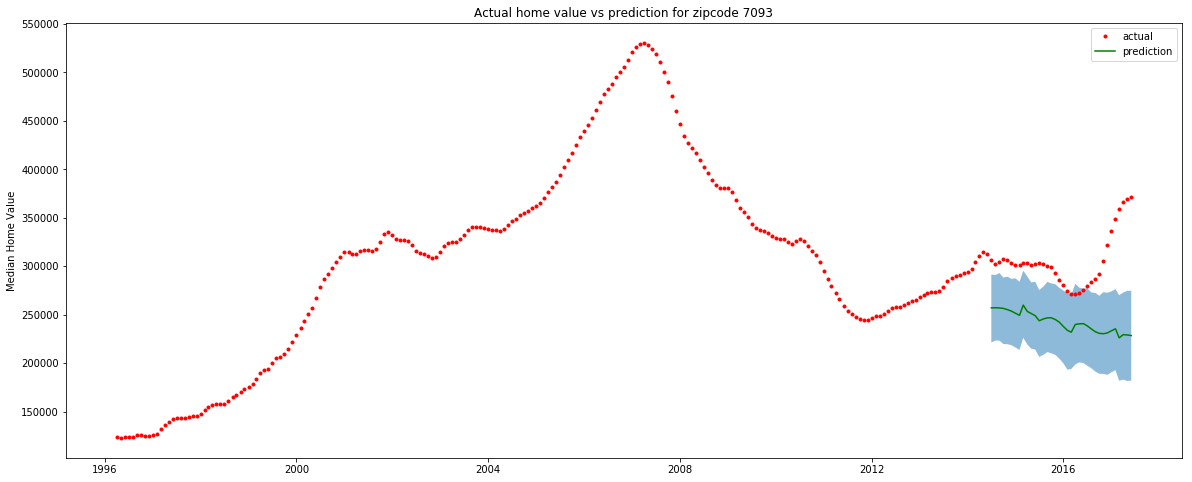

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10021


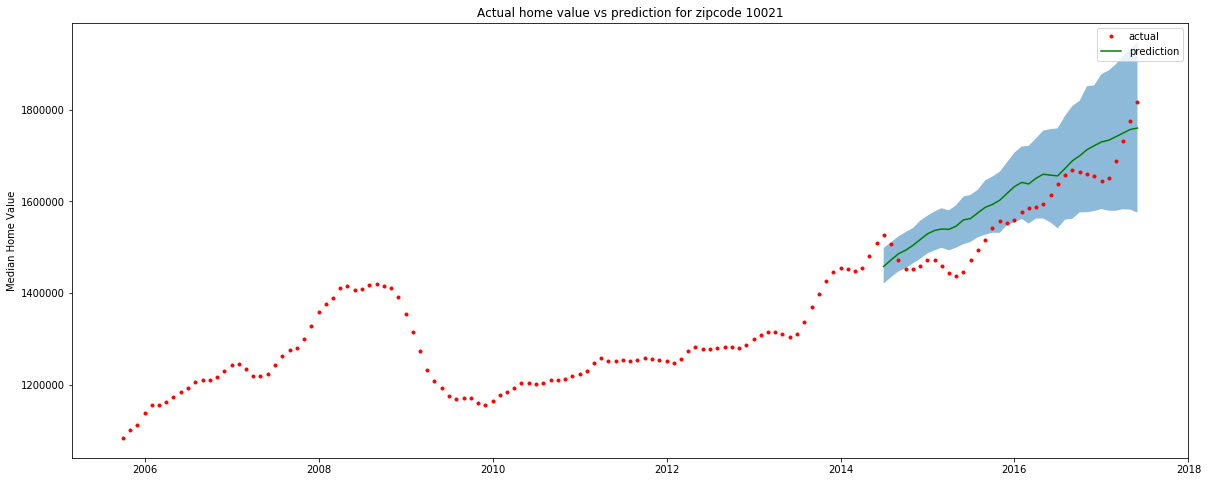

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7302


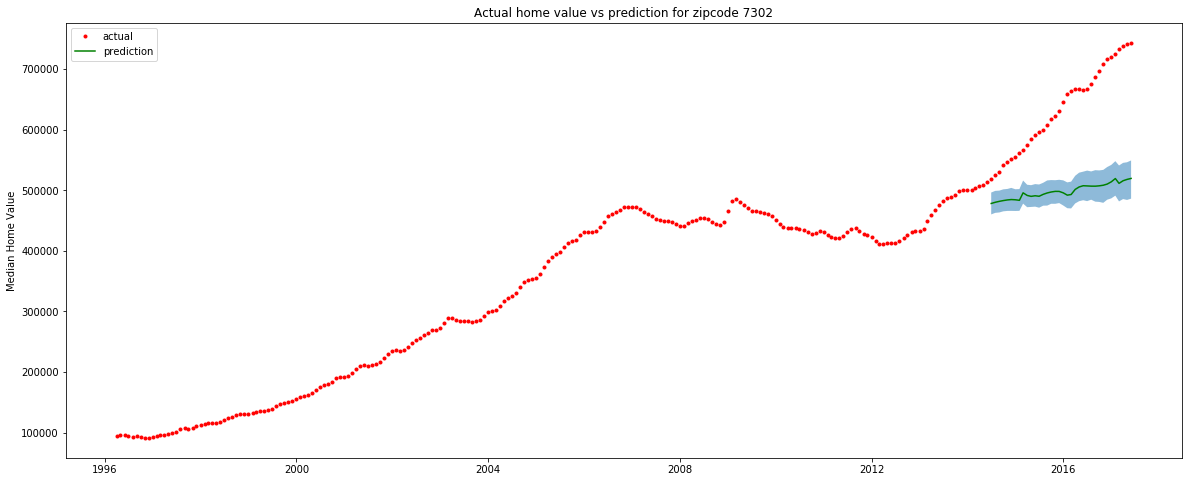

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10014


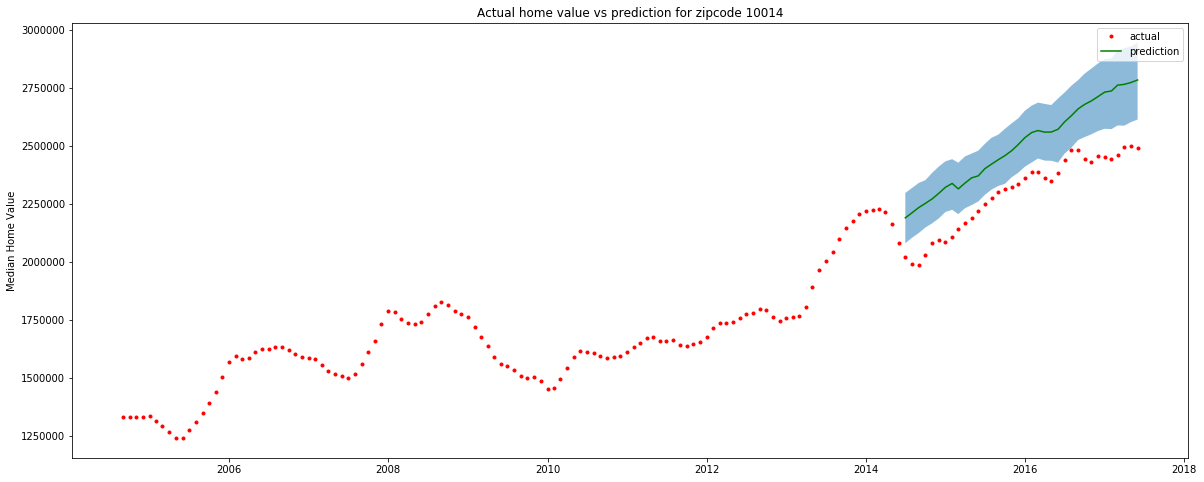

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10036


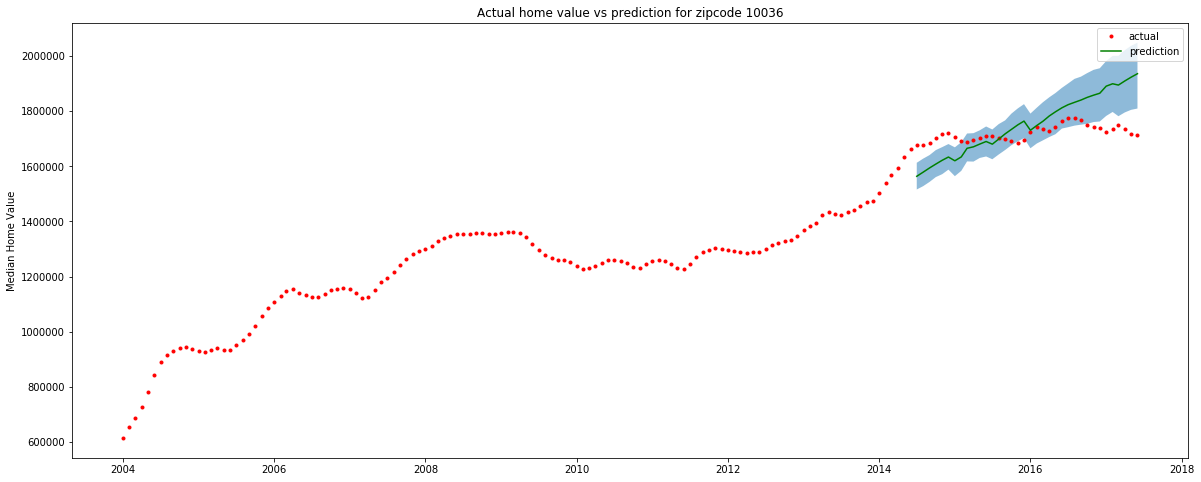

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11434


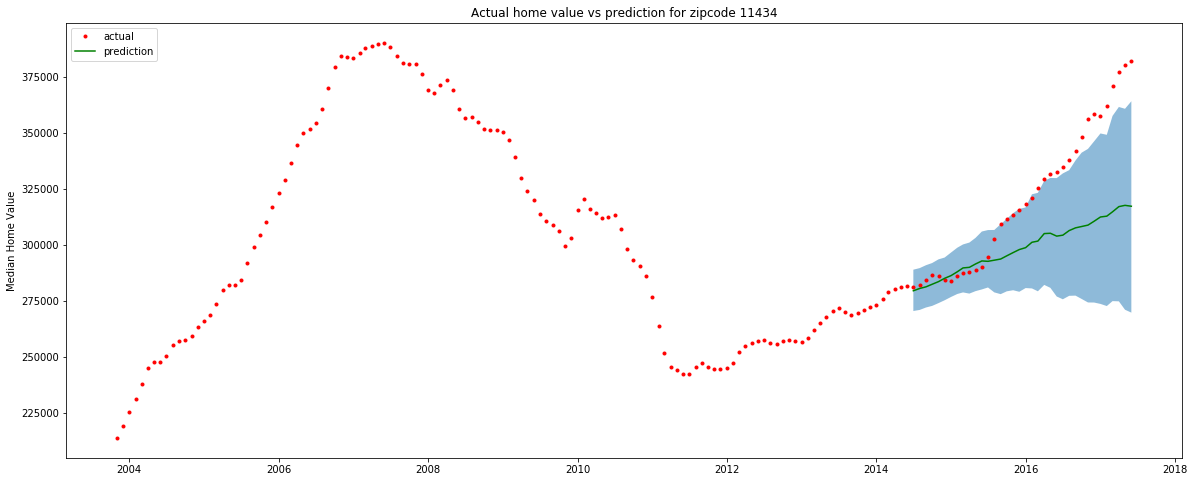

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10306


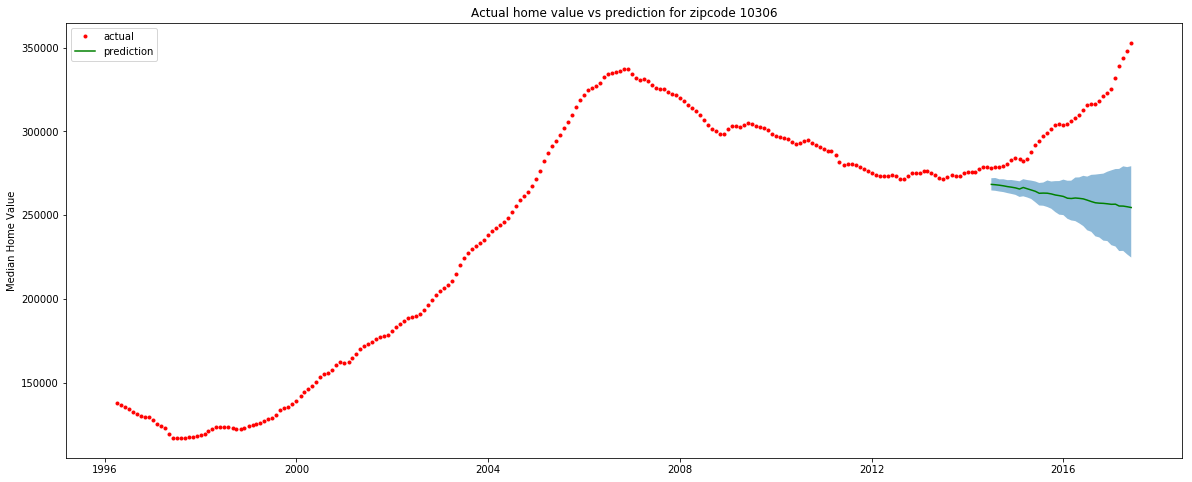

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10312


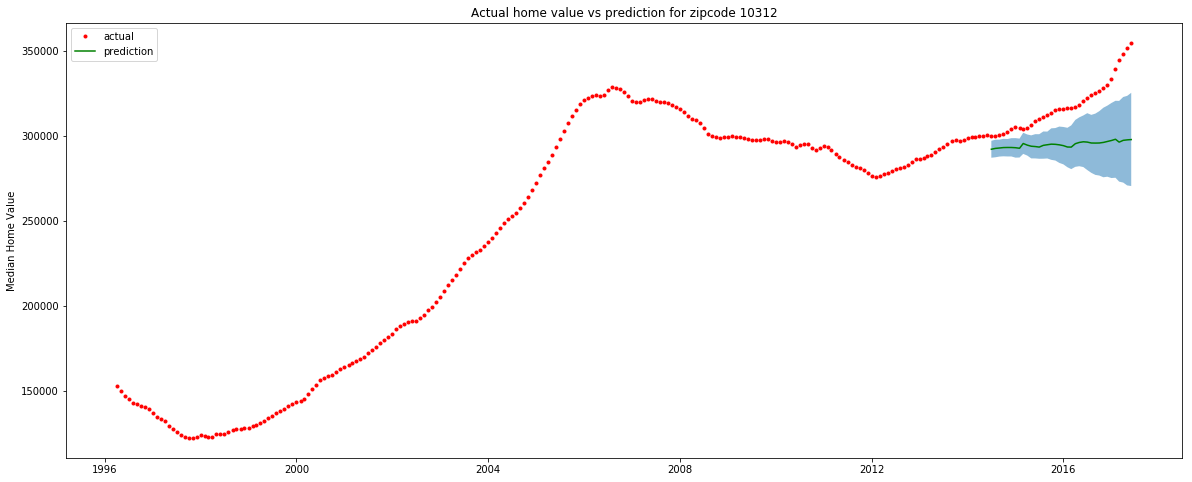

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10022


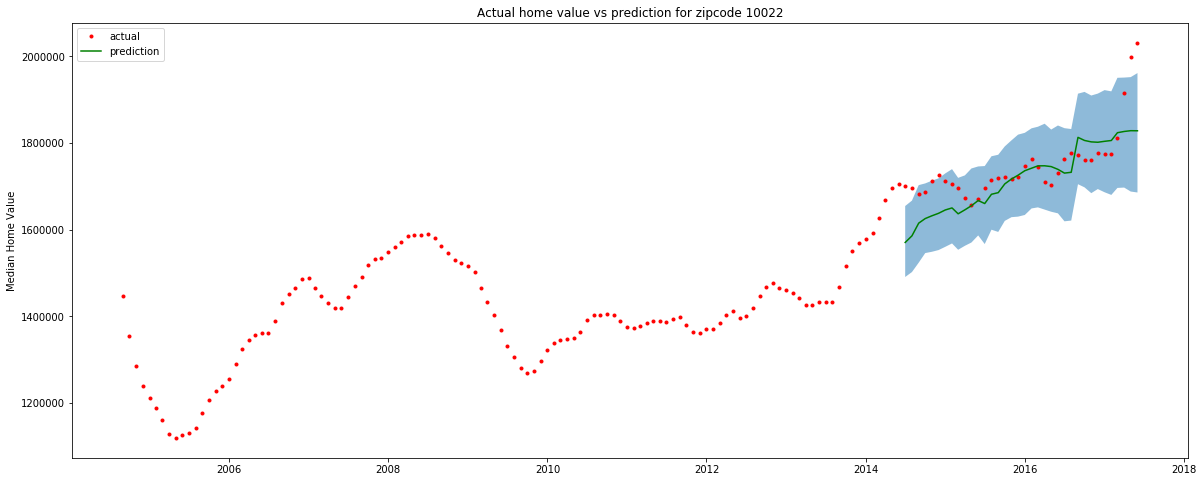

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11217


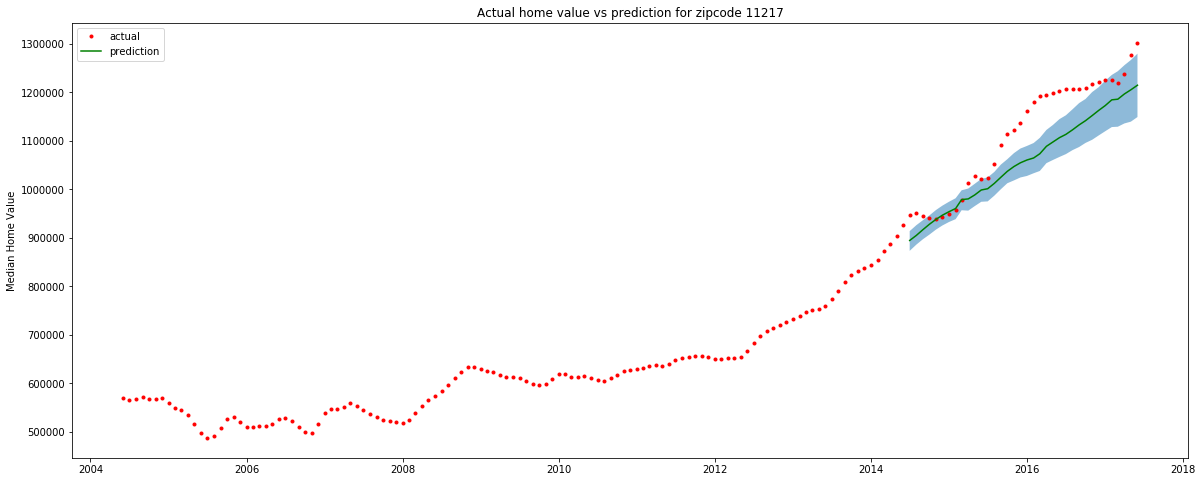

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10013


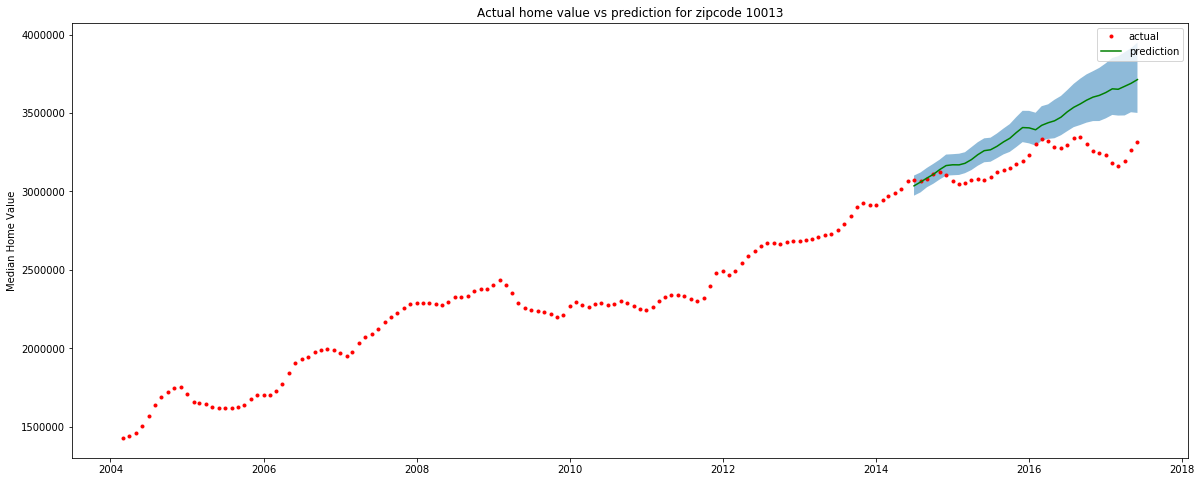

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11231


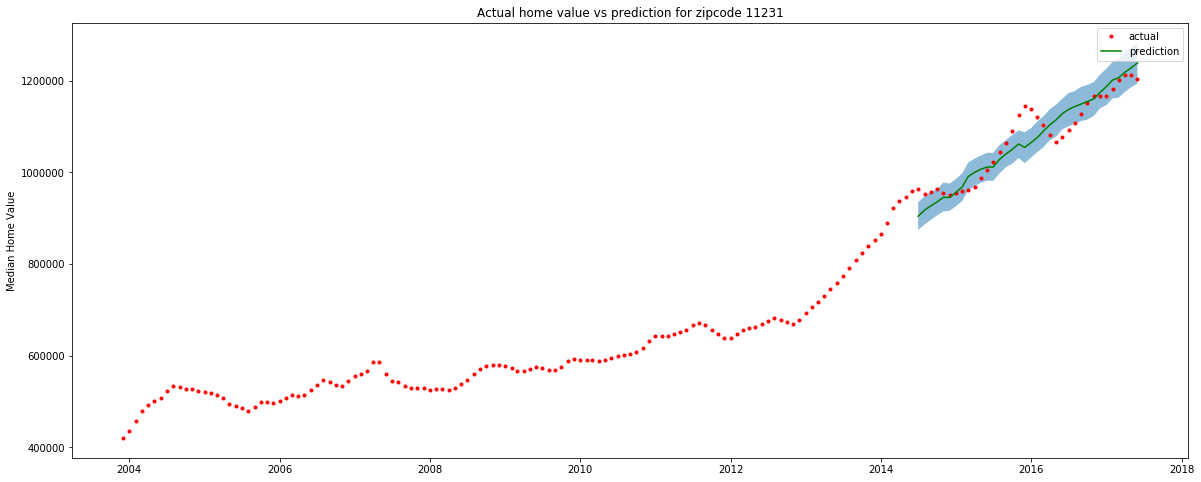

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10304


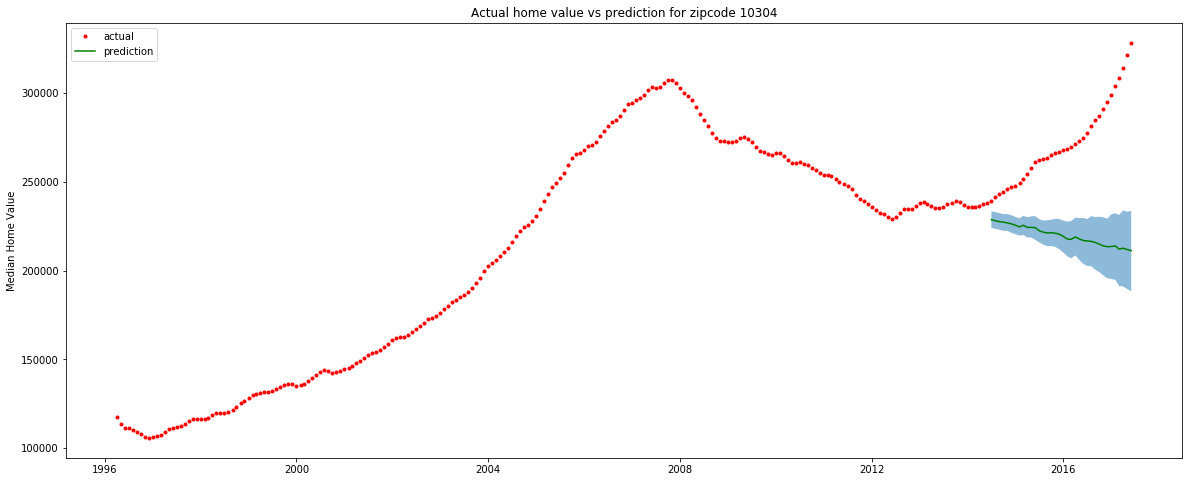

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10305


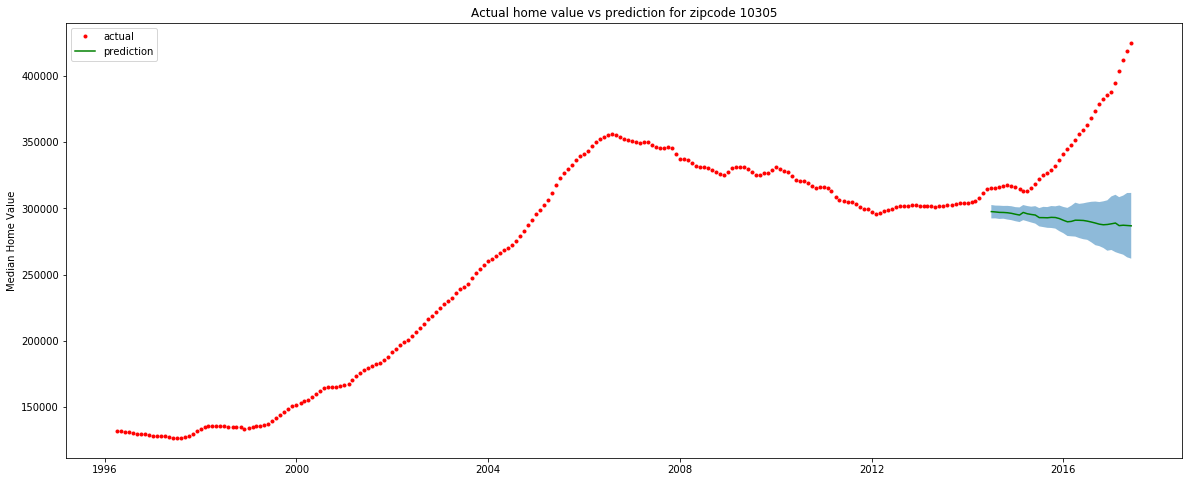

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10704


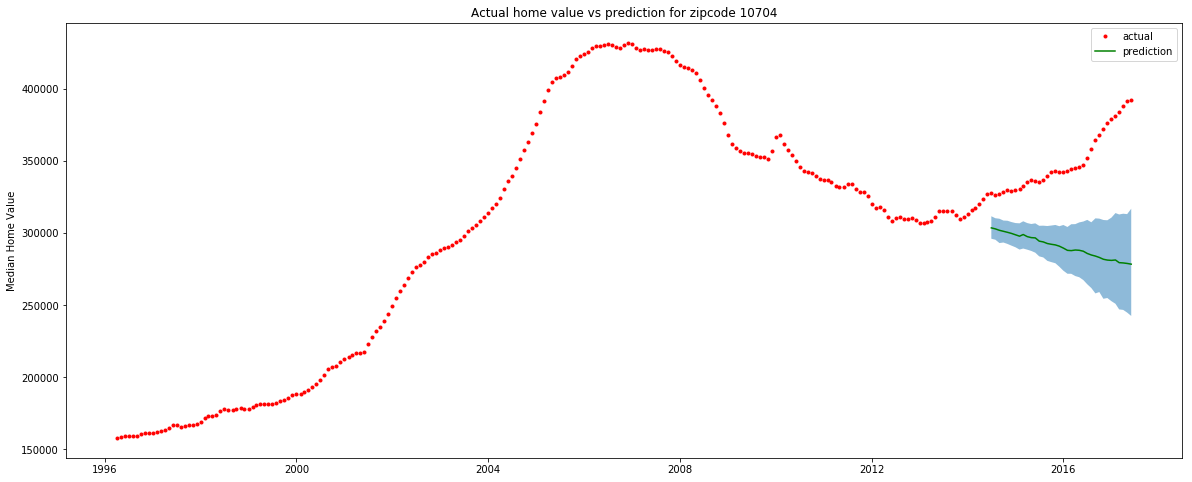

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11003


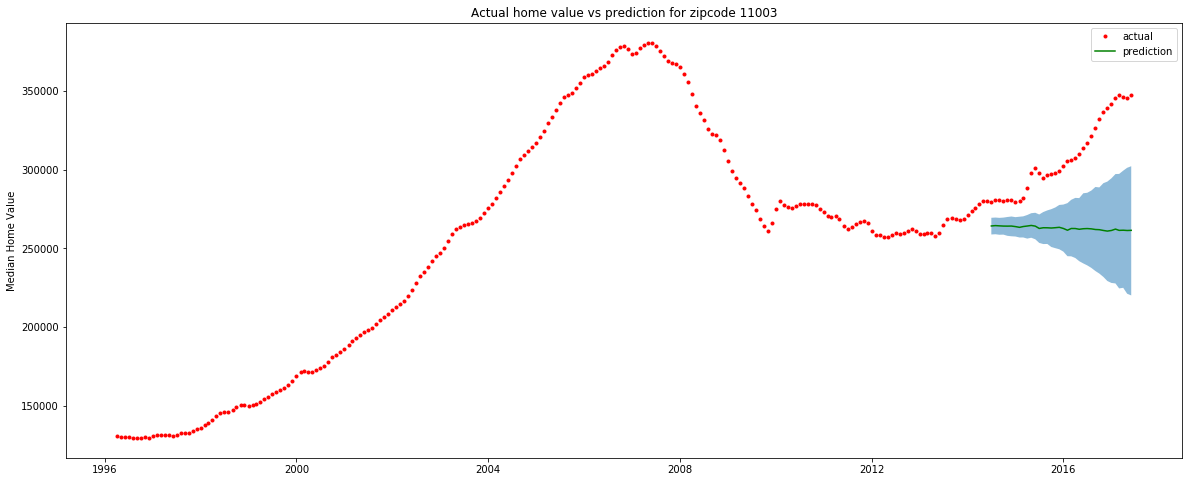

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10309


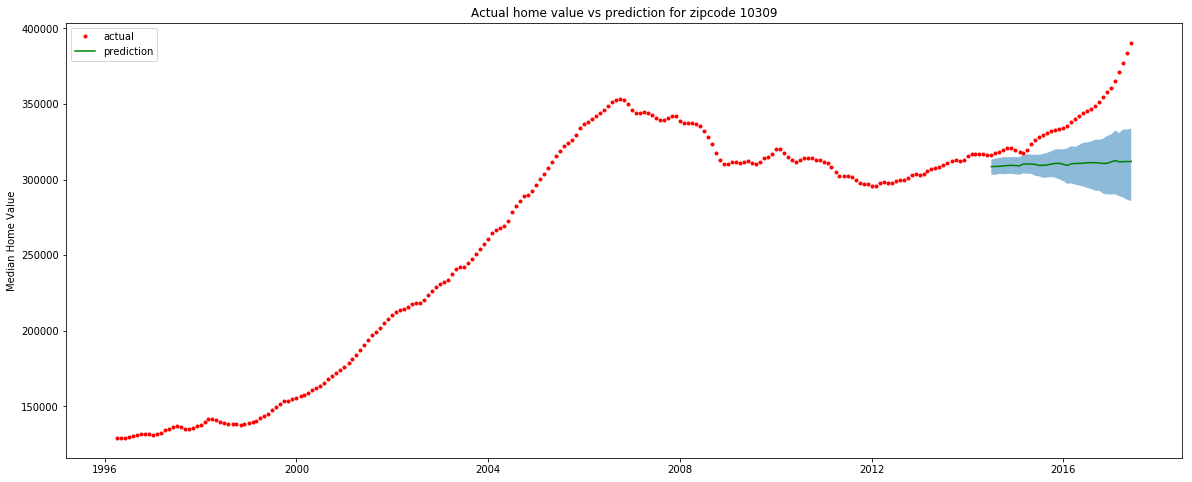

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10308


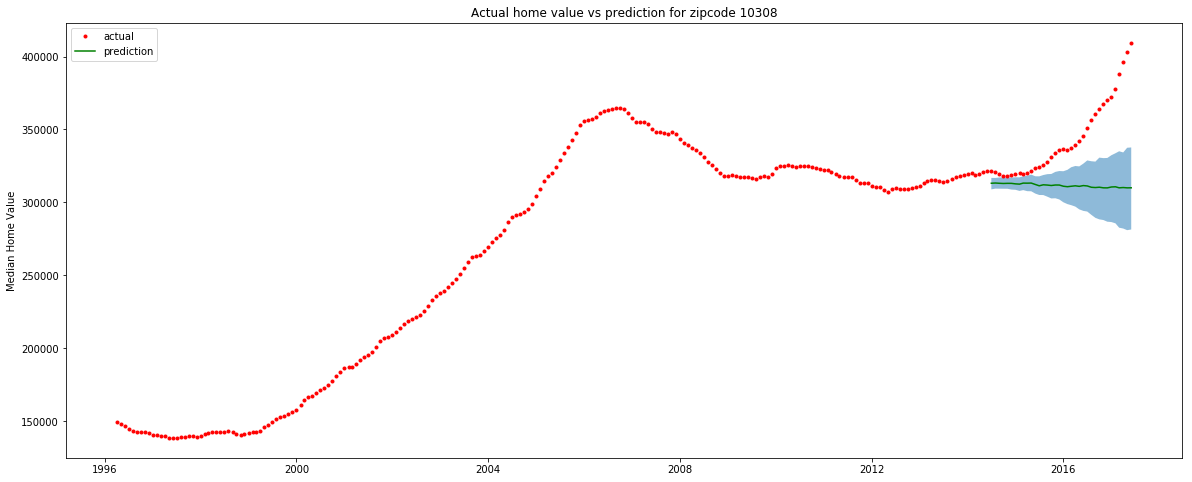

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10303


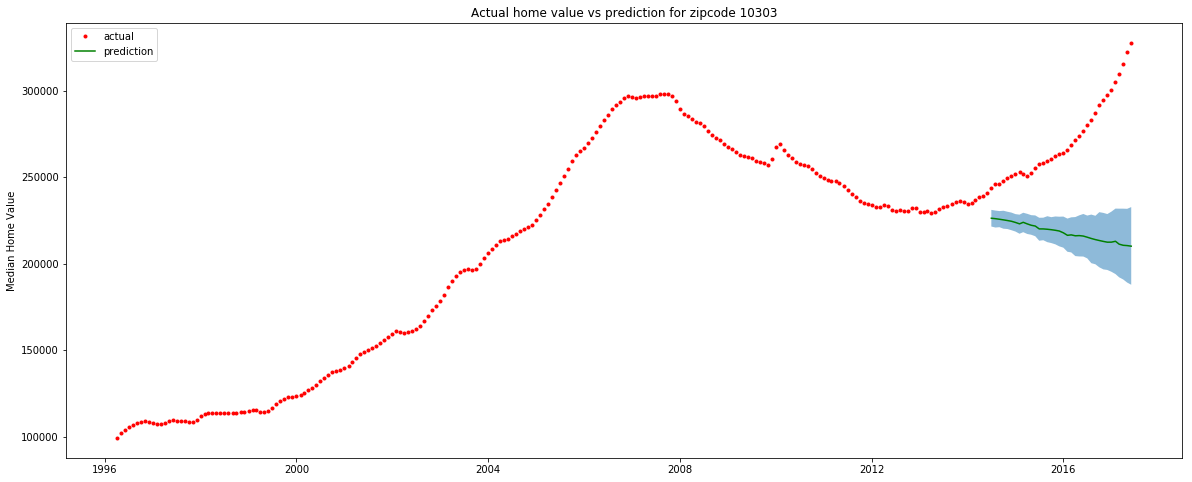

In [15]:
for zipcode in zillow.RegionName:
    print(zipcode)
    actual_data, train_data = prepare_data(zillow_melted, zipcode, prediction_period)
    pred_data , _ = make_prediction(train_data, prediction_period = prediction_period, boxcox_transformed = False)
    comp_df = actual_data.merge(pred_data, how ='outer').set_index('ds')
    error = calculate_forecast_errors(comp_df, prediction_period)
    MAPE_ntrnf.append(error['MAPE'])
    MAE_ntrnf.append(error['MAE'])
    comparison_plot(comp_df,zipcode, prediction_period , True)

In [16]:
# The inversed boxcox process generated infinite values, so I did not use boxcox transformation 

# for zipcode in zillow.RegionName:
#     print(zipcode)
#     actual_data, train_data = prepare_data(zillow_melted,  zipcode)
#     pred_data , lamb = make_prediction(train_data, prediction_period = prediction_period, boxcox_transformed = True)
#     #print(pred_data)
#     comp_df = actual_data.merge(pred_data, how ='outer').set_index('ds')
#     error = calculate_forecast_errors(comp_df, prediction_period)
#     MAPE_boxcox.append(error['MAPE'])
#     MAE_boxcox.append(error['MAE'])

In [17]:
print('Loss on nontransformed data')
print('MAPE total is {}'.format(sum(MAPE_ntrnf)))
print('MAE total is {}'.format(sum(MAE_ntrnf)))

Loss on nontransformed data
MAPE total is 268.58898145567605
MAE total is 2127738.2472716765


In [18]:
# use Prophet to make prediction 
chunks = []
for zipcode in zillow.RegionName:
    actual_data, train_data = prepare_data(zillow_melted,  zipcode, prediction_period)
    pred_data , _ = make_prediction(actual_data, prediction_period = prediction_period, boxcox_transformed = False)
    predicted_part = pred_data.loc[-prediction_period:, ['ds','yhat']]
    predicted_part['zipcode'] = zipcode
    chunks.append(predicted_part)

full_pred = pd.concat(chunks, ignore_index=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [19]:
full_pred.tail()

,ds,yhat,zipcode
6698,2020-02-01,348556.447011,10303
6699,2020-03-01,350267.768309,10303
6700,2020-04-01,352448.895895,10303
6701,2020-05-01,354856.495606,10303
6702,2020-06-01,356923.650576,10303


# Rental Revenue - Airbnb Listing
In data quality checking phase, listings that are not `Entire home/apt` were filtered out. Because the listing data were scraped from Airbnb, there would be some listing that the hosts do not intend to rent out anymore but don't care deactivate the listing. I would deem those as inactive listing, thus should not be considered as pairly priced for rental market.Thus, I want to filter out listings which have last reviews dating back to 1 years ago. This could also filter out new listings which are hosted by active hosts. So I keep listings that have the last reviews at most 1 year ago and new listings with 0 reviews but availability were updated within 2 months. After filtering, there are 20,405 listings left. 

I took the median price of 2-bed listing as the expected rental revenue. I excluded boat/RV/Yurt/Houseboat/Resort in the analysis.

From Figure2, we can see that most of the 2-bed listings are priced between 100 to 400 dollars per night.

In [20]:
# check how many years ago the listing received last review.
listing['last_review'] = pd.to_datetime(listing['last_review'])
listing['calendar_last_scraped'] = pd.to_datetime(listing['calendar_last_scraped'])
listing['last_review_period']= round((listing['calendar_last_scraped'] - listing['last_review'])/np.timedelta64(1,'Y'),2)

In [21]:
targets = ['days', 'weeks', '2 months']
# keep listings that have the last reviews at most 1 year ago 
# and new listings with 0 reviews but availability were updated within 2 months.
listing = listing[(listing['last_review_period'] <= 1.00) | \
                (listing['number_of_reviews'] == 0 & \
                 listing.calendar_updated.apply(lambda words: any(word in words for word in targets)))]
print('After filtering, there are {} listings left.'.format(listing.shape[0]))

After filtering, there are 20405 listings left.


listing.to_csv('listing_cleaned_active.csv', index = False)

In [22]:
# number of listings for each zipcode
listing_zip_total = listing.groupby('zipcode')[['id']].count().reset_index().rename(columns = {'id':'total'})
# keep 2-bed listings
listing_2 = listing[listing['bedrooms'] == 2]
print('There are {} 2-bed listings'.format(listing_2.shape[0]))

There are 4938 2-bed listings


In [23]:
listing_2.head(2)

,id,last_scraped,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,last_review,number_of_reviews,last_review_period
10,7750,2019-07-08,"New York, NY, United States",East Harlem,Manhattan,New York,NY,10029.0,New York,US,United States,40.79685,-73.94872,Apartment,Entire home/apt,4,1.0,2.0,Real Bed,750.0,190.0,NaN,NaN,NaN,NaN,1,0.0,7 weeks ago,t,4,14,14,249,2019-07-08,NaT,0,NaN
22,14290,2019-07-08,"Brooklyn, NY, United States",Williamsburg,Brooklyn,Brooklyn,NY,11206.0,New York,US,United States,40.70420,-73.93560,Loft,Entire home/apt,2,1.0,2.0,Real Bed,NaN,228.0,NaN,NaN,350.0,128.0,2,10.0,today,t,14,20,50,140,2019-07-08,2019-05-17,82,0.14


In [24]:
np.unique(listing_2.property_type)

array(['Apartment', 'Bed and breakfast', 'Boat', 'Boutique hotel',
       'Bungalow', 'Cabin', 'Camper/RV', 'Condominium', 'Cottage',
       'Guest suite', 'Guesthouse', 'House', 'Houseboat', 'Loft', 'Other',
       'Resort', 'Serviced apartment', 'Townhouse', 'Villa', 'Yurt'],
      dtype=object)

In [25]:
# it is very unlikely that the company will be investing in a boat/RV/Yurt/Houseboat/Resort, so I will remove those
listing_2 = listing_2[~listing_2.property_type.isin(['Yurt','Boat', 'Camper/RV','Houseboat', 'Other', 'Resort'])] 
print('After excluding novel property type, there are {} listings left.'.format(listing_2.shape[0]))

After excluding novel property type, there are 4923 listings left.


In [26]:
# calculate quantile of availability
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

In [27]:
listing_2_zip = listing_2.groupby('zipcode')\
                         .agg({'price':['median','mean','std'], 
                               'id':'count', 
                               'availability_90':['median', q1, q2]})
listing_2_zip.columns = listing_2_zip.columns.droplevel(0)
listing_2_zip.reset_index(inplace = True)
listing_2_zip = listing_2_zip.merge(listing_zip_total, on ='zipcode')
listing_2_zip['2bed%'] = listing_2_zip['count']/listing_2_zip['total']
listing_2_zip.columns = ['zipcode', 'price_median', 'price_mean', 'price_std', 'count_2b_list', 
                         'avb_median', 'avb_25q', 'avb_75q', 'count_all_list', '2bed%']

# we can see that there is only 1 2-bed listing in zipcode 10281, and it was priced extremely high.
listing_2_zip.sort_values('price_median', ascending=False).head(5)

,zipcode,price_median,price_mean,price_std,count_2b_list,avb_median,avb_25q,avb_75q,count_all_list,2bed%
39,10069.0,750.0,750.0,NaN,1,85.0,85.00,85.00,12,0.083333
44,10270.0,650.0,650.0,0.000000,2,80.5,78.75,82.25,11,0.181818
47,10282.0,650.0,650.0,NaN,1,0.0,0.00,0.00,4,0.250000
5,10006.0,599.0,488.0,284.248131,3,0.0,0.00,7.50,39,0.076923
41,10110.0,422.0,422.0,NaN,1,65.0,65.00,65.00,1,1.000000


Text(0.5, 1.0, 'Figure2. Median price vs. % of 2-bed listings for each zipcode')

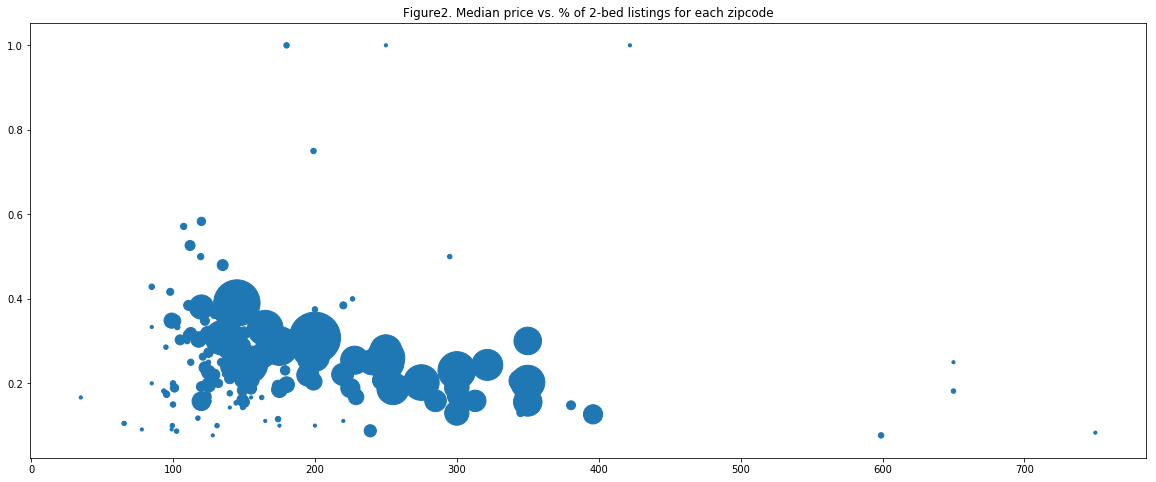

In [28]:
plt.figure(figsize= (20,8))
plt.scatter(x=listing_2_zip['price_median'],
                 y=listing_2_zip['2bed%'],
                 s=listing_2_zip['count_2b_list']*10)
plt.title('Figure2. Median price vs. % of 2-bed listings for each zipcode')

# ROI - Where to invest?
Now we calculate ROI for each zipcode, the home values predicted for Feburary 2020 are used as investment amount. Assuming 75% yearly occupancy rate on average, the expected yearly revenue for each zipcode are calculated.

Some of the zipcodes have less than 10 listings, not sufficient enough sample size to give a representative rental price for that area. Thus, I excluded zipcodes that have less than 10 2-bed listings from the potential candidate selection.

According to NYC Company market report, New York enjoys its busiest travel season from July to September with hotel occupancy rate hitting 90%. Since all the rental data were scraped in 2019 July, the `availability_90` show a cursory estimation of how popular an area is in terms of booked ratio. Thus, I pick the potential investament zipcode not only based on pure ROI but also the popularity. 

Indeed, some Airbnb listings have better amenities and better reviews, thus are more likely to be fully booked. But if 75% of the listings in an area enjoy higher occupancy rate than that place is more likely to be popular with visitors, where there are demands await to be met, so that my friend can easily fill out vacancy for their property.

turn to tableau dashaboard for visaulization

In [29]:
roi_df = listing_2_zip.merge(full_pred[full_pred.ds == '2020-02-01'][['yhat','zipcode']], on ='zipcode')
occupancy_rate = 0.75
roi_df['yearly_revenue'] = roi_df['price_median'] * 365 * occupancy_rate
roi_df['ROI'] = roi_df['yearly_revenue']/ roi_df['yhat']
roi_df.sort_values(by = 'ROI', ascending = False, inplace = True)

In [30]:
roi_df.head(10)
roi_df = roi_df[roi_df.count_2b_list >= 10]

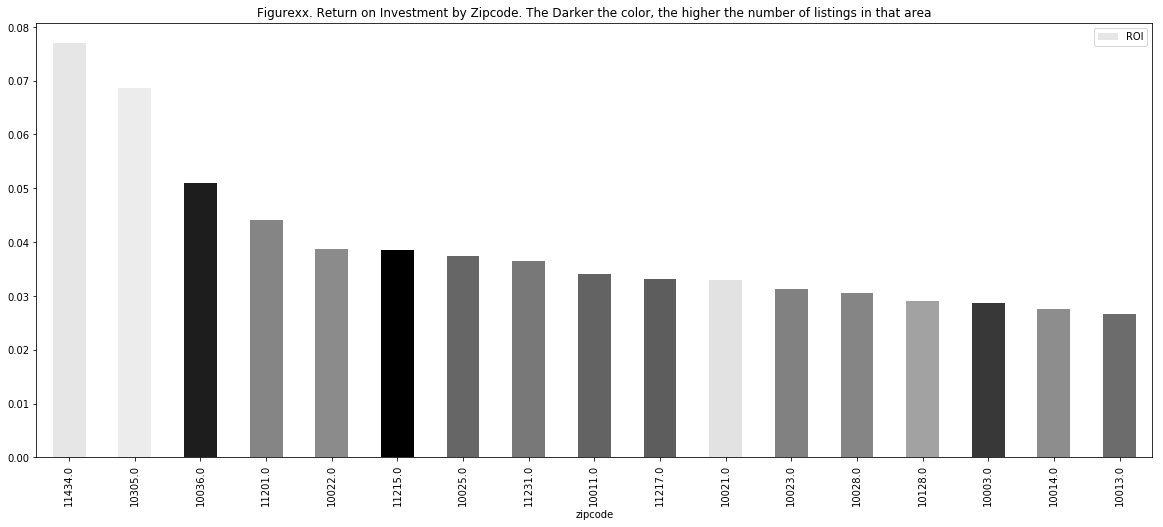

In [31]:
alphas = roi_df['count_2b_list'] / float(max(roi_df['count_2b_list']))
rgba_colors = np.zeros((roi_df.shape[0],4))
# for red the first column needs to be one
rgba_colors[:,0] = 0.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
#plt.bar(roi_df.zipcode, roi_df.ROI, color=rgba_colors, width = 2)
roi_df.plot(x = 'zipcode', y='ROI',kind='bar', color = rgba_colors, figsize = (20,8), legend = True, 
            title = 'Figurexx. Return on Investment by Zipcode. The Darker the color, the higher the number of listings in that area')
plt.show()

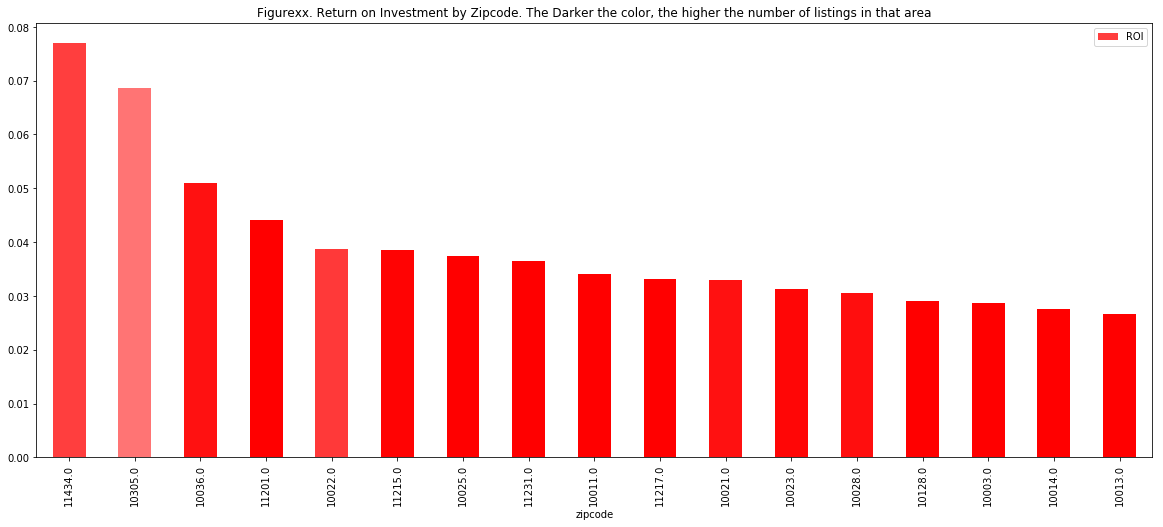

In [32]:
# Availability for future 3 months for the top 25% booked listings
# the darker the color, more days are booked for future 
alphas = (90 - roi_df['avb_25q']) / float(max(90 - roi_df['avb_25q']))
rgba_colors = np.zeros((roi_df.shape[0],4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
#plt.bar(roi_df.zipcode, roi_df.ROI, color=rgba_colors, width = 2)
roi_df.plot(x = 'zipcode', y='ROI',kind='bar', color = rgba_colors, figsize = (20,8), legend = True, 
            title = 'Figurexx. Return on Investment by Zipcode. The Darker the color, the higher the number of listings in that area')
plt.show()

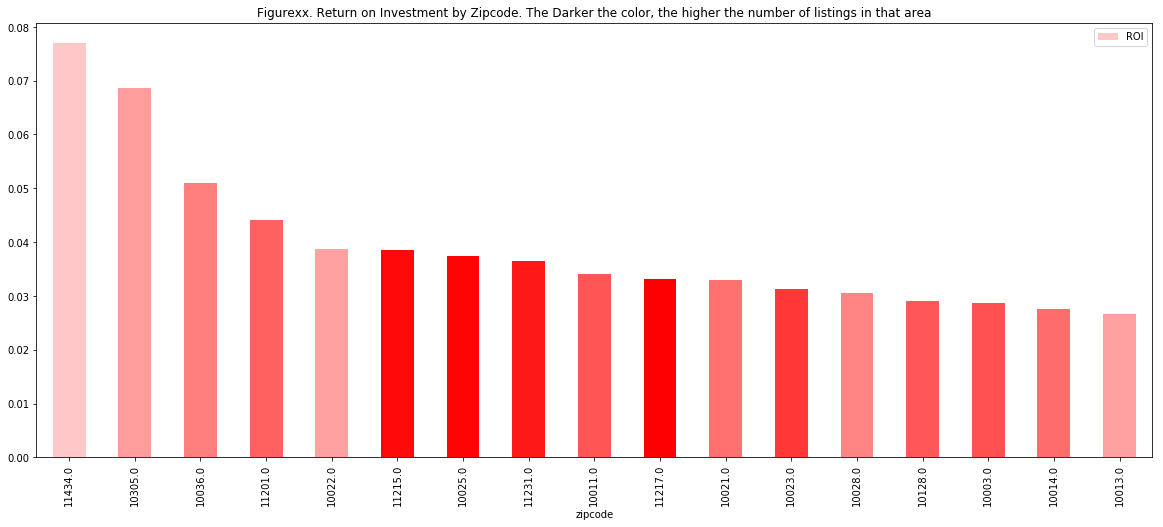

In [33]:
# Availability for future 3 months for the top 25% booked listings
# the darker the color, more days are booked for future 
alphas = (90 - roi_df['avb_75q']) / float(max(90 - roi_df['avb_75q']))
rgba_colors = np.zeros((roi_df.shape[0],4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
#plt.bar(roi_df.zipcode, roi_df.ROI, color=rgba_colors, width = 2)
roi_df.plot(x = 'zipcode', y='ROI',kind='bar', color = rgba_colors, figsize = (20,8), legend = True, 
            title = 'Figurexx. Return on Investment by Zipcode. The Darker the color, the higher the number of listings in that area')
plt.show()

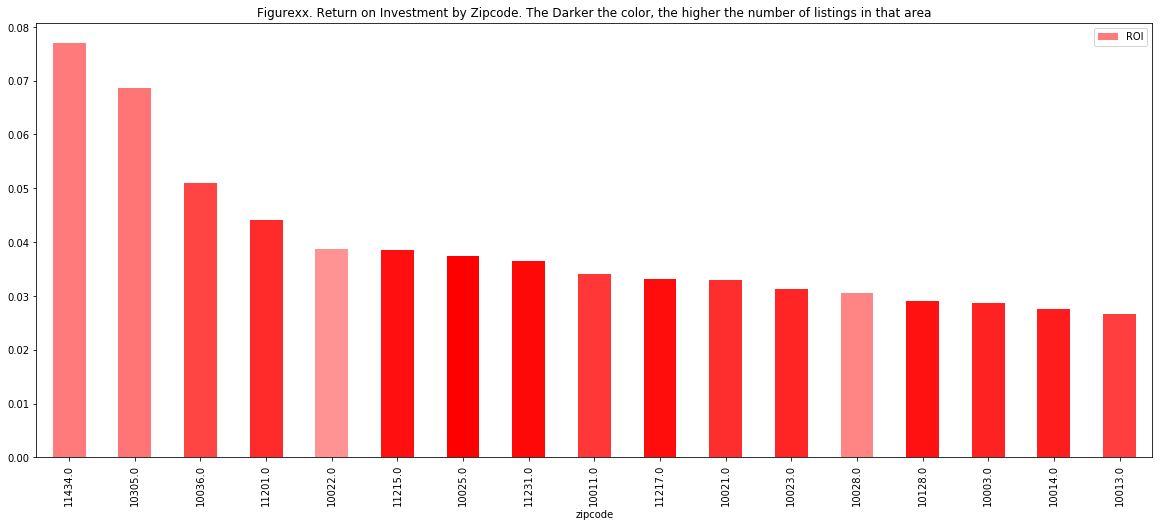

In [34]:
# Availability for future 3 months for the top 25% booked listings
# the darker the color, more days are booked for future 
alphas = (90 - roi_df['avb_median']) / float(max(90 - roi_df['avb_median']))
rgba_colors = np.zeros((roi_df.shape[0],4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphas
#plt.bar(roi_df.zipcode, roi_df.ROI, color=rgba_colors, width = 2)
roi_df.plot(x = 'zipcode', y='ROI',kind='bar', color = rgba_colors, figsize = (20,8), legend = True, 
            title = 'Figurexx. Return on Investment by Zipcode. The Darker the color, the higher the number of listings in that area')
plt.show()

In [35]:
roi_df.to_csv('roi_df.csv', index = False)

In [38]:
listing.head(2)

,id,last_scraped,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,last_review,number_of_reviews,last_review_period
0,2595,2019-07-09,"New York, NY, United States",Midtown,Manhattan,New York,NY,10018.0,New York,US,United States,40.75362,-73.98377,Apartment,Entire home/apt,2,1.0,0.0,Real Bed,NaN,225.0,1995.0,NaN,350.0,100.0,2,0.0,4 days ago,t,25,55,80,355,2019-07-09,2019-05-21,45,0.13
1,3831,2019-07-09,"Brooklyn, NY, United States",Clinton Hill,Brooklyn,Brooklyn,NY,11238.0,New York,US,United States,40.68514,-73.95976,Guest suite,Entire home/apt,3,1.0,1.0,Real Bed,500.0,89.0,575.0,2100.0,500.0,NaN,1,0.0,today,t,0,0,3,194,2019-07-09,2019-07-05,270,0.01
